# Bibliotheken und Funktionen Importieren

In [1362]:
# Bibliotheken importieren
import pandas as pd
import numpy as np
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import (make_scorer, 
                             precision_score, 
                             recall_score, 
                             precision_recall_curve,
                             average_precision_score,
                            # PrecisionRecallDisplay,
                             f1_score, 
                             accuracy_score, 
                             roc_auc_score, 
                             roc_curve, 
                             confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# Daten einlesen und Organisieren

In [1363]:
# Daten laden
#df = pd.read_csv('../../Data_Processing/whole_cleaned_dataset.csv')
df = pd.read_csv('../../Data_Processing/no_transformer_data.csv')

# Features und Zielspalte
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Stratified Folds und K-Folds Erstellen

In [1364]:
# Stratified K-Fold und K-Fold einrichten
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
#skf = KFold(n_splits=5, shuffle=True, random_state=0)

# Parameter für Grid Search


In [1365]:
param_grid = {
    'C':      [0.01, 0.1, 1, 10, 100],   # Best Result = 1  ;  Später war 0.1 Bestes Resultat
    #'C':    [0.8, 0.9, 1, 1.1, 1,2],     # Best Result = 0.8
    #'C':    [0.5, 0.6, 0.7, 0.8, 0.9],  # Best Result = 0.8
    #'C':    [0.75, 0.775, 0.8, 0.825, 0.85],    # Best Result = 0.825
    #'C':    [0.05, 0.1, 0.15, 0.2, 0.25],        # Best Result = 0.1
    'penalty':['l1', 'l2'],
    'solver': ['liblinear'],  # liblinear unterstützt l1 und l2
}


# GridSearchCV mit AUC als Optimierungsziel
grid = GridSearchCV(
    estimator = LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid = param_grid,
    cv         = skf,
    #scoring    = 'roc_auc',
    scoring    = 'recall',
    n_jobs     = -1,        # alle CPUs nutzen
    verbose    = 1
)


# Hyperparameter Tuning

In [1366]:
"""
# Grid Search durchführen
grid.fit(X, y)
# Resultate zurückgeben
print("Best Parameters: ", grid.best_params_)
#print("Best Mean AUC:   ", grid.best_score_)
print("Best Mean Recall:   ", grid.best_score_)

"""

'\n# Grid Search durchführen\ngrid.fit(X, y)\n# Resultate zurückgeben\nprint("Best Parameters: ", grid.best_params_)\n#print("Best Mean AUC:   ", grid.best_score_)\nprint("Best Mean Recall:   ", grid.best_score_)\n\n'

# Best Hyperparameter Model auswählen

In [1367]:
"""
best_model = grid.best_estimator_
#print(best_model)
"""

'\nbest_model = grid.best_estimator_\n#print(best_model)\n'

# Metriken Listen 

In [1368]:
# Metriken speichern
precision_list = []
recall_list = []
specificity_list = []
accuracy_list = []
f1_list = []
auc_list = []

#Metriken für ROC-Kurve
mean_fpr = np.linspace(0, 1, 100)
tprs = []
conf_matrices = []

#Metriken für PR-Kurve
mean_recall = np.linspace(0, 1, 200)
tprs_interp = []      # hier speichern wir für jeden Fold die Precision interpoliert auf mean_recall
aps = []              # Average Precision pro Fold

# Cross Valiation 

In [1369]:
# Cross-Validation Schleife
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


    # Hyperparameter tuning
    grid.fit(X_train, y_train)
    # Resultate zurückgeben
    print("Best Parameters: ", grid.best_params_)
    #print("Best Mean AUC:   ", grid.best_score_)
    print("Best Mean Recall:   ", grid.best_score_)
    best_model = grid.best_estimator_


    """Select best_model for ML to use the best Hyperparameter"""
    #model = LogisticRegression(class_weight='balanced', max_iter=1000)
    best_model.fit(X_train, y_train)

    # Vorhersagen und Wahrscheinlichkeiten
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]  #für die ROC Kurve

    # Metriken berechnen
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    specificity_list.append(recall_score(y_test, y_pred, pos_label=0))
    f1_list.append(f1_score(y_test, y_pred))
    accuracy_list.append(accuracy_score(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    auc_list.append(auc)

    # Confusion Matrix berechnen
    cm = confusion_matrix(y_test, y_pred)

    conf_matrices.append(cm)

    # ROC-Kurve für jeden Fold
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tprs.append(tpr_interp)

    print(f"Fold {fold}: Precision={precision_list[-1]:.2f}, Recall={recall_list[-1]:.2f}, Specificity={specificity_list[-1]:.2f}, Accuracy={accuracy_list[-1]:.2f} F1={f1_list[-1]:.2f}, AUC={auc:.2f}")

    
    """ Failed PR-Kurven Code
    # PR-Kurve für jeden Fold
    # Precision, Recall und AP
    precision, recall, __ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    aps.append(ap)

    # Precision interpolieren auf gemeinsame recall-Achse
    #    precision_recall_curve gibt recall sortiert ab 1.0 → 0.0, daher invertieren
    precision_interp = np.interp(mean_recall,
                                 recall[::-1],        # ascending
                                 precision[::-1])     # entsprechend precision
    tprs_interp.append(precision_interp)
    """


    


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Mean Recall:    0.7520487264673312
Fold 1: Precision=0.63, Recall=0.70, Specificity=0.78, Accuracy=0.75 F1=0.67, AUC=0.82
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Mean Recall:    0.7849390919158361
Fold 2: Precision=0.56, Recall=0.63, Specificity=0.73, Accuracy=0.69 F1=0.59, AUC=0.81
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Mean Recall:    0.762126245847176
Fold 3: Precision=0.59, Recall=0.81, Specificity=0.70, Accuracy=0.74 F1=0.69, AUC=0.83
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Mean Recall:    0.7627906976744186
Fold 4: Precision=0.65, Recall=0.79, Specificity=0.77, Acc

# PR-Kurve (Incomplete)

In [1370]:
"""
# Einzelne PR-Kurve plotten
#plt.plot(recall, precision, lw=1, alpha=0.6, label=f"Fold {fold} (AP={ap:.2f})")


# ROC-Kurven aller Folds plotten
plt.figure(figsize=(10, 8))
for i, precision_interp in enumerate(tprs_interp):
    plt.plot(recall, precision, lw=1, alpha=0.7, label=f"PR Fold {i + 1} (PR {i+1} = {aps[i]:.2f})")

# Mean-Curve berechnen
mean_precision = np.mean(tprs_interp, axis=0)
std_precision  = np.std(tprs_interp, axis=0)

# Mean-Curve plotten + ±1 STD-Band
plt.plot(mean_recall, mean_precision, color="black",
         lw=2, label=f"Mean PR (±1 STD)\nAP={np.mean(aps):.2f}±{np.std(aps):.2f}")


plt.fill_between(mean_recall,
                 mean_precision - std_precision,
                 mean_precision + std_precision,
                 color="gray", alpha=0.2)


# Plot-Details
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall-Kurven über alle Folds")
plt.legend(loc="lower left", fontsize=9)
plt.grid(linestyle="--", alpha=0.5)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()
"""

'\n# Einzelne PR-Kurve plotten\n#plt.plot(recall, precision, lw=1, alpha=0.6, label=f"Fold {fold} (AP={ap:.2f})")\n\n\n# ROC-Kurven aller Folds plotten\nplt.figure(figsize=(10, 8))\nfor i, precision_interp in enumerate(tprs_interp):\n    plt.plot(recall, precision, lw=1, alpha=0.7, label=f"PR Fold {i + 1} (PR {i+1} = {aps[i]:.2f})")\n\n# Mean-Curve berechnen\nmean_precision = np.mean(tprs_interp, axis=0)\nstd_precision  = np.std(tprs_interp, axis=0)\n\n# Mean-Curve plotten + ±1 STD-Band\nplt.plot(mean_recall, mean_precision, color="black",\n         lw=2, label=f"Mean PR (±1 STD)\nAP={np.mean(aps):.2f}±{np.std(aps):.2f}")\n\n\nplt.fill_between(mean_recall,\n                 mean_precision - std_precision,\n                 mean_precision + std_precision,\n                 color="gray", alpha=0.2)\n\n\n# Plot-Details\nplt.xlabel("Recall")\nplt.ylabel("Precision")\nplt.title("Precision-Recall-Kurven über alle Folds")\nplt.legend(loc="lower left", fontsize=9)\nplt.grid(linestyle="--", alp

# ROC Kurven für alle Folds und Mean ROC Kurve


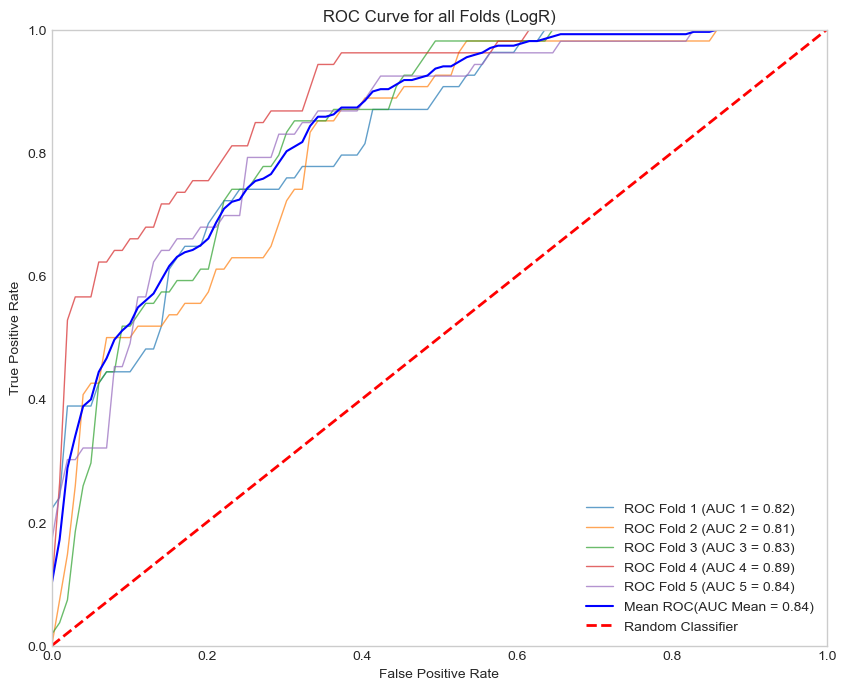

In [1377]:
# ROC-Kurven aller Folds plotten
plt.figure(figsize=(10, 8))
for i, tpr in enumerate(tprs):
    plt.plot(mean_fpr, tpr, lw=1, alpha=0.7, label=f"ROC Fold {i + 1} (AUC {i+1} = {auc_list[i]:.2f})")

mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(auc_list)
plt.plot(mean_fpr, mean_tpr, color='b', label=f"Mean ROC(AUC Mean = {mean_auc:.2f})", lw=1.5)                            # Die Mean ROC Kurve
#plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 Std. Dev.')      #Der Std Bereich (Grau)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2, label='Random Classifier')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds (LogR)')
plt.legend(loc="lower right")
plt.grid()

# Show Plot comment the line if you want to save it
#plt.show()

#save fig
plt.savefig('../../output/Log_R_output/ROC_kurven_LogR.png')

# Feature Importance  


Absolute Values:

Glucose                     0.507126
BMI                         0.276789
Pregnancies                 0.174981
Age                         0.165020
Insulin                     0.163769
SkinThickness               0.156709
DiabetesPedigreeFunction    0.133518
BloodPressure               0.015059
dtype: float64


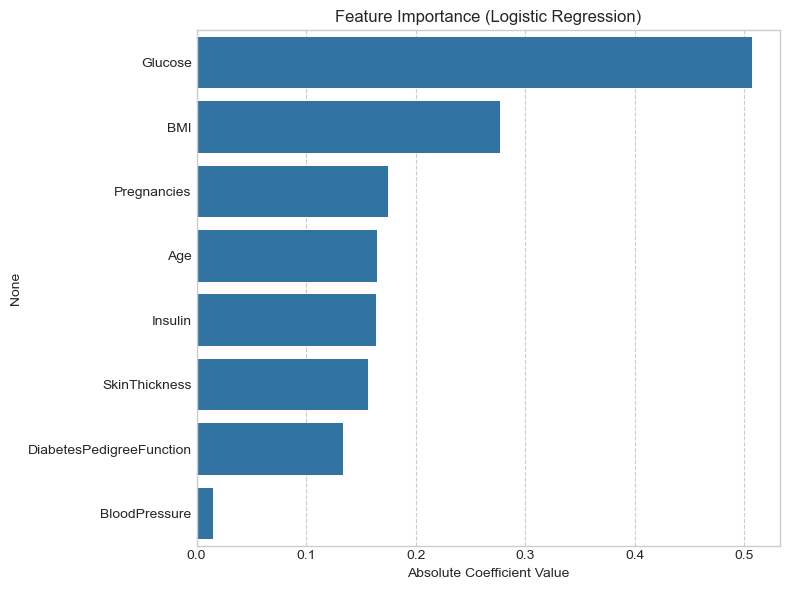

In [1372]:
# Koeffizienten aus dem Modell ziehen (für LogReg)
coefs = best_model.coef_[0]

# In eine Pandas Series umwandeln und sortieren
feat_imp = pd.Series(coefs, index=X_train.columns)
feat_imp_abs = feat_imp.abs().sort_values(ascending=False)  # Absolut Values
#feat_imp = feat_imp.sort_values(ascending=False)            # Keine Absolute Values

"""
# Print Feature Importance
print(feature_importance)
print("")
"""

#Gib die Feature Importance in Absteigender Reihenfolge zurück
#print(feat_imp)            # Nicht Abolut Values
print("")
print("Absolute Values:")
print("")
print(feat_imp_abs)         # Absolute Values


plt.figure(figsize=(8, 6))
sns.barplot(x=feat_imp_abs.values, y=feat_imp_abs.index, orient='h')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance (Logistic Regression)')
plt.grid(axis='x', linestyle='--', alpha=1)
plt.tight_layout()
plt.show()

# Feature Importance using Shap

c:\Users\georg\anaconda3\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


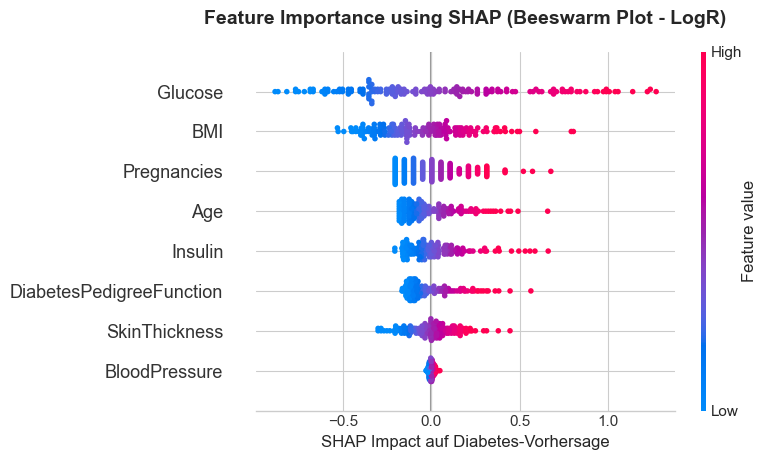

In [1373]:
# SHAP Explainer für lineare Modelle
explainer = shap.LinearExplainer(best_model, X_train, feature_perturbation="interventional")

# SHAP-Werte berechnen (für jede Test-Instanz und jedes Feature)
shap_values = explainer.shap_values(X_test)

# Globale Feature-Bedeutung (Bar-Plot)
#shap.summary_plot(shap_values, X_test, plot_type="bar")


# Style setzen (optional, für grauen Hintergrund)
plt.style.use('seaborn-v0_8-whitegrid')

# Beeswarm-Plot
shap.summary_plot(
    shap_values,          # SHAP-Werte für positive Klasse
    X_test,               # DataFrame mit Feature-Spalten
    show=False,           # Disable Auto Show
    plot_type='dot',      # 'dot' ist Default – kann weggelassen werden
    color_bar_label='Feature value',
    title='SHAP Summary (Beeswarm plot)- LogR'
)

# 2) Titel setzen
plt.title("Feature Importance using SHAP (Beeswarm Plot - LogR)",fontsize=14, fontweight="bold", pad=20)
# Nach dem summary_plot:
plt.xlabel("SHAP Impact auf Diabetes-Vorhersage", fontsize=12)

plt.tight_layout()  # Ränder anpassen
plt.savefig('../../output/Log_R_output/Shap_feature_importance_LogR.png')

# Mean Confusion Matrix 

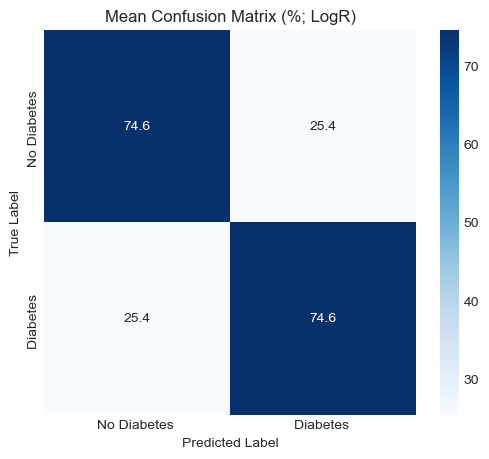

In [1374]:
# Mean Confusion Matrix berechnen und plotten
mean_conf_matrix = np.mean(conf_matrices, axis=0) # absolute Mean Werte 

mean_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True) * 100  # Macht aus absoluten relative Werte für Confusion Matrix

plt.figure(figsize=(6, 5))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".1f", cmap="Blues", 
            xticklabels=["No Diabetes ", "Diabetes "],
            yticklabels=["No Diabetes ", "Diabetes "])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Mean Confusion Matrix (%; LogR)')
#plt.show()

# Save fig 
plt.savefig('../../output/Log_R_output/Mean_cm_LogR.png')

# Durchschnitt und Standardabweichung der Metriken

=== Durchschnitt und Standardabweichung der Metriken ===
F1-Score: Mittelwert = 0.671, Standardabweichung = 0.043
F1-Score: 0.671 ± 0.043 

Recall: Mittelwert = 0.747, Standardabweichung = 0.070
Recall: 0.747 ± 0.070 

Precision: Mittelwert = 0.612, Standardabweichung = 0.032
Precision: 0.612 ± 0.032 

Accuracy: Mittelwert = 0.746, Standardabweichung = 0.029
Accuracy: 0.746 ± 0.029 

AUC: Mittelwert = 0.839, Standardabweichung = 0.026
AUC: 0.839 ± 0.026 

      Metric      Mean       Std
0   F1-Score  0.671467  0.042784
1     Recall  0.746611  0.069829
2  Precision  0.611665  0.032027
3   Accuracy  0.746159  0.028517
4        AUC  0.838572  0.026419


C:\Users\georg\AppData\Local\Temp\ipykernel_18948\652573361.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Metric', y='Mean', palette='Blues_d')


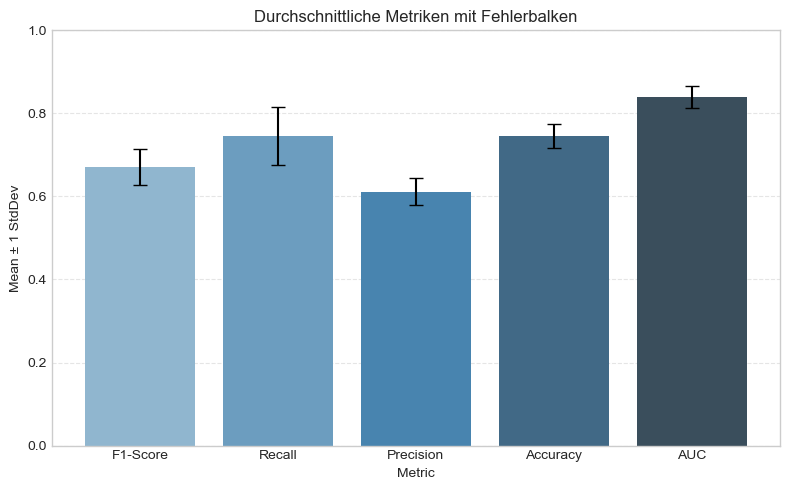

In [1375]:
# Zusammenfassung der Metriken
metrics = {
    "F1-Score": (np.mean(f1_list), np.std(f1_list)),
    "Recall": (np.mean(recall_list), np.std(recall_list)),
    #"Specificity": (np.mean(specificity_list), np.std(specificity_list)),
    "Precision": (np.mean(precision_list), np.std(precision_list)),
    "Accuracy": (np.mean(accuracy_list), np.std(accuracy_list)),
    "AUC": (np.mean(auc_list), np.std(auc_list))
}

print("=== Durchschnitt und Standardabweichung der Metriken ===")
for metric, (mean, std) in metrics.items():
    print(f"{metric}: Mittelwert = {mean:.3f}, Standardabweichung = {std:.3f}")
    print(f"{metric}: {mean:.3f} ± {std:.3f} ")
    print("")








# In DataFrame umwandeln
df = pd.DataFrame(metrics).T.reset_index()
df.columns = ['Metric', 'Mean', 'Std']

print(df)


plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df, x='Metric', y='Mean', palette='Blues_d')

# Manuell Fehlerbalken hinzufügen
for i, row in df.iterrows():
    ax.errorbar(
        i,             # x-Position des Balkens
        row['Mean'],   # Mittelwert
        yerr=row['Std'],  # Standardabweichung
        fmt='none',    # kein Marker
        c='black',     # Farbe
        capsize=5      # Querstrichgröße
    )

plt.ylim(0, 1)
plt.ylabel('Mean ± 1 StdDev')
plt.title('Durchschnittliche Metriken mit Fehlerbalken')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Metriken in Datei speichern

In [1376]:
summary = {
    'Model':          ['LogisticRegression'],
    'F1_Mean':        [np.mean(f1_list)],
    'F1_Std':         [np.std(f1_list)],
    'Recall_Mean':    [np.mean(recall_list)],
    'Recall_Std':     [np.std(recall_list)],
    'Precision_Mean': [np.mean(precision_list)],
    'Precision_Std':  [np.std(precision_list)], 
    'Accuracy_Mean':  [np.mean(accuracy_list)],
    'Accuracy_Std':   [np.std(accuracy_list)],
    'ROC_AUC_Mean':   [np.mean(auc_list)],
    'ROC_AUC_Std':    [np.std(auc_list)],
}

# In einen DataFrame umwandeln
summary_df = pd.DataFrame(summary)

# Als CSV speichern
summary_df.to_csv('../../Data_Processing/logreg_summary_metrics.csv', index=False)

print("Übersicht gespeichert als 'logreg_summary_metrics.csv':")
print(summary_df)


"""
summary_pdf = pd.DataFrame(metrics)



print(summary_pdf)

summary_pdf.to_csv('../../Data_Processing/logR_summary_metrics.csv', index=False)
"""

Übersicht gespeichert als 'logreg_summary_metrics.csv':
                Model   F1_Mean    F1_Std  Recall_Mean  Recall_Std  \
0  LogisticRegression  0.671467  0.042784     0.746611    0.069829   

   Precision_Mean  Precision_Std  Accuracy_Mean  Accuracy_Std  ROC_AUC_Mean  \
0        0.611665       0.032027       0.746159      0.028517      0.838572   

   ROC_AUC_Std  
0     0.026419  


"\nsummary_pdf = pd.DataFrame(metrics)\n\n\n\nprint(summary_pdf)\n\nsummary_pdf.to_csv('../../Data_Processing/logR_summary_metrics.csv', index=False)\n"